In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.cm as cm

In [2]:
def outgoingRadiation(greenhouseCoefficient, temperature):
    '''
    how much energy is leaving our object.

    the higher the temperature is, the more energy is leaving.
    the lower temperature is, less energy leaves

    temperature leaving is modulated by greenhouse coeffecient. it tells us how much energy is kept on the planet due to greenhouse effect
    1 - greenhouseCoefficient tells us how much energy escapes despite greenhouse effect
    '''
    stefanBoltzmannConstant = 5.67e-8
    return (1 - greenhouseCoefficient) * stefanBoltzmannConstant * (temperature ** 4)

def rateOfTemperatureChange(energyComingIn, energyGoingOut, heatCapacity):
    '''
    heatCapacity is how much energy is required to change the temperature of an object.
    energyComingIn - energyGoingOut tells us the net change.

    if more energyIsLeaving, then according to the heatcapacity temp will be decreased by certain amount
    and vice versa
    '''
    return (energyComingIn - energyGoingOut) / heatCapacity

def temperatureChangeEulersMethod(temperatureOld, rateOfTemperatureChange, timeStep):
    '''
    update temperature based on rateOfTemperatureChange and timeStep added to old temp
    '''
    return temperatureOld + (rateOfTemperatureChange * timeStep)

In [57]:
def variableIncomingSolarRadiation(maxRadiation, timestep, timestepsInDay, latitudeBands):
    '''
    simulate day/night cycle to determine incoming solar energy.
    use 1st cos to vary amount of incoming solar energy scaled on maxRadiation (noon)
    use max(0, cos(...)) so when cos is negative, the incoming solar radiation is 0 not negative since negative solar energy doesnt make sense
    2nd cos to vary solar radiation based on latitude
    '''
    return maxRadiation * max(0, math.cos((2 * math.pi * timestep) / timestepsInDay)) * np.maximum(0, np.cos(np.radians(latitudeBands)))

In [4]:
def heatDiffusionBetweenLatitudes(temperatures, diffusionConstant, timestep):
    '''
    heat is transferred between latitudes based on the latitude above and below
    D(T_i+1​−T_i​)+D(T_i−1​−T_i​) where T_i represents temperature at latitude i and D diffusion constant
    rearranges to D * (T_i+1 - 2Ti + T_i-1 )
    this represents that temperature is gained/lost based on surrounding latitudes. if both T_i+1 and T_i-1 are very big then this will be positive and mean lots of temperature increase
    if T_i is big and T_i+1 and T_i-1 are small then this will be negative and mean lots of temperature decrease

    this is scaled based on diffusionConstant and the number of timesteps

    to be clear this is not the new temperature but based on the difference between latitudes, how much the temperature will change
    '''
    return diffusionConstant * (np.roll(temperatures, -1) - 2 * temperatures + np.roll(temperatures, 1)) * timestep

In [95]:
totalTimesteps = 10_000
startingTemperature = 250
heatCapacity = 1e7
timestepSeconds = 15 # seconds
timestepSecondsForDay = 86400
# incomingSolarRadiation = 240
maxIncomingSolarRadiation = 900
numLatitudes = 18+1
latitudeBands = np.linspace(90, -90, numLatitudes)
numLongitudes = 18*2 # from -180 to 180 including 0 but -180 and 180 are same
longitudeBands = np.linspace(-180, 180, numLongitudes+1)[:-1]

greenhouseCoefficient = 0.3
diffusionConstant = 0

In [96]:
temperatures = []
currentTemperatures = np.full((numLatitudes,numLongitudes), 250)
incomingSolarEnergy = []
for t in range(0, totalTimesteps*timestepSeconds, timestepSeconds):
    outgoingEnergy = outgoingRadiation(greenhouseCoefficient, currentTemperatures)

    incomingSolarRadiation = variableIncomingSolarRadiation(maxIncomingSolarRadiation, t, timestepSecondsForDay, latitudeBands)
    incomingSolarRadiationForEachTile = np.tile(incomingSolarRadiation, (numLongitudes, 1)).T

    rateOfTempChange = rateOfTemperatureChange(incomingSolarRadiationForEachTile, outgoingEnergy, heatCapacity)
    # print(rateOfTempChange[:, 0])
    # print((rateOfTempChange * timestepSeconds)[:, 0])
    # print((currentTemperatures + (rateOfTempChange * timestepSeconds))[:, 0])
    currentTemperatures = temperatureChangeEulersMethod(currentTemperatures, rateOfTempChange, timestepSeconds)
    # print(currentTemperatures[:, 0])
    heatDiffusion = heatDiffusionBetweenLatitudes(currentTemperatures, diffusionConstant, timestepSeconds)
    currentTemperatures += heatDiffusion
    # print(currentTemperatures[:, 0])

    temperatures.append(currentTemperatures)
    if np.isnan(currentTemperatures.max()) or t > 6000:
        break
    else:
        print(currentTemperatures.max())


250.00111744140625
250.00223487785135
250.00335230772887
250.00446972943243
250.00558714135562
250.00670454189205
250.00782192943535
250.0089393023792
250.0100566591172
250.0111739980431
250.01229131755056
250.01340861603333
250.01452589188517
250.01564314349986
250.01676036927122
250.0178775675931
250.01899473685936
250.02011187546393
250.02122898180076
250.02234605426386
250.02346309124724
250.024580091145
250.02569705235126
250.02681397326018
250.02793085226597
250.02904768776293
250.03016447814534
250.0312812218076
250.03239791714415
250.0335145625495
250.03463115641816
250.03574769714479
250.03686418312404
250.03798061275066
250.03909698441947
250.04021329652534
250.04132954746325
250.0424457356282
250.04356185941532
250.0446779172198
250.04579390743686
250.04690982846188
250.0480256786903
250.0491414565176
250.05025716033938
250.05137278855136
250.0524883395493
250.0536038117291
250.05471920348666
250.0558345132181
250.05694973931955
250.05806488018732
250.05917993421775
250.0602

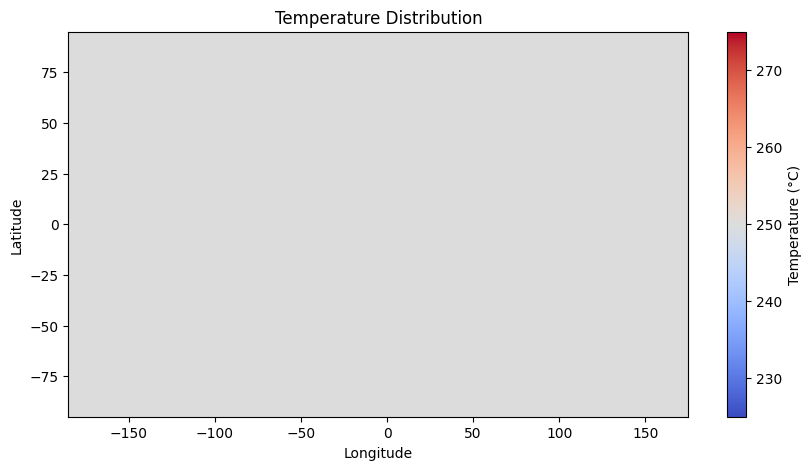

In [45]:
lon = np.arange(-180, 180, 10)  # From -180 to 170 in steps of 10
lat = np.arange(-90, 100, 10)

plt.figure(figsize=(10, 5))
plt.pcolormesh(lon, lat, temperatures[-1], shading='auto', cmap='coolwarm')

# Add labels and title
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Temperature Distribution")
plt.colorbar(label="Temperature (°C)")

# Show the plot
plt.show()

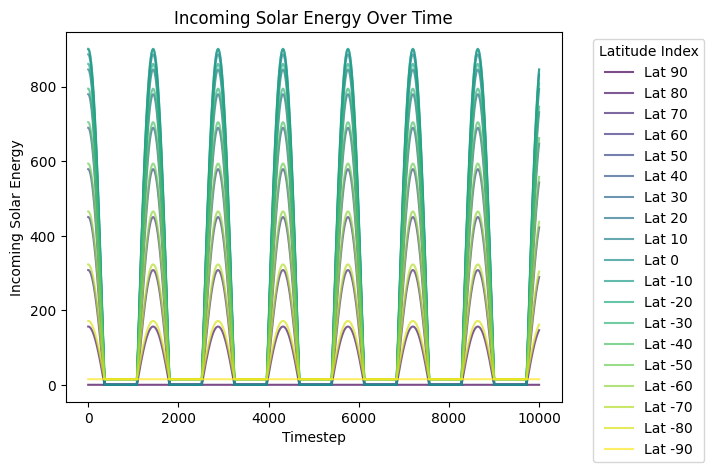

In [ ]:
npSolarEnergy = np.array(incomingSolarEnergy)
colors = cm.viridis(np.linspace(0, 1, npSolarEnergy.shape[1]))
for latIdx in range(npSolarEnergy.shape[1]):
    if latIdx > 9:
        nudge = 15
    else:
        nudge = 0
    plt.plot(np.arange(totalTimesteps), npSolarEnergy[:, latIdx]+nudge, label=f"Lat {int(latitudeBands[latIdx])}", color=colors[latIdx], alpha=0.7)
plt.xlabel("Timestep")
plt.ylabel("Incoming Solar Energy")
plt.title("Incoming Solar Energy Over Time")
plt.legend(title="Latitude Index", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()